Prerequisites: install [tensorflow 1.0](https://www.tensorflow.org/install/) and  [scikit-image](http://scikit-image.org/docs/dev/api/skimage.html).

clone this fork of [tf-slim](https://github.com/marcotcr/tf-models) somewhere
download [the pretrained model](http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz) and put it in tf-models/slim/pretrained/

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
#!pip install --upgrade tf_slim
#!pip install lime

In [3]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as slim
slim = slim
import sys
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


## Create a predict fn for inception v3, takes in a list of images and returns a matrix of prediction probabilities

In [4]:
from tf_slim.nets import inception
import inception_preprocessing

In [5]:
session = tf.Session()

2022-08-09 10:51:22.364598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        with open(f, 'rb') as i:
            contents = i.read()
        image_raw = tf.image.decode_jpeg(contents, channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [7]:
import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

In [8]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [9]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = os.getcwd()
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)


/opt/software/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


INFO:tensorflow:Restoring parameters from /notebooks/lime/doc/notebooks/inception_v3.ckpt


In [10]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

## Let's see the top 5 prediction for some image

286 Egyptian cat 0.0009032647
218 English springer, English springer spaniel 0.00094700506
233 Border collie 0.0010646327
215 Gordon setter 0.001095368
239 Greater Swiss Mountain dog 0.017993955
242 EntleBucher 0.021648414
241 Appenzeller 0.052724484
240 Bernese mountain dog 0.8183818


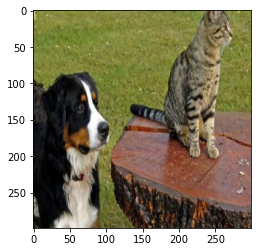

In [11]:
images = transform_img_fn(['dogs.png'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-8:]:
    print(x, names[x], preds[0,x])

In [12]:
image = images[0]

In [13]:
## Now let's get an explanation

In [14]:
from lime import lime_image
import time

In [15]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [16]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

303.9148488044739


Image classifiers are a bit slow. Notice that an explanation in my macbookpro took 7.33 minutes

### Now let's see the explanation for the top class (Bernese mountain dog)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [17]:
from skimage.segmentation import mark_boundaries

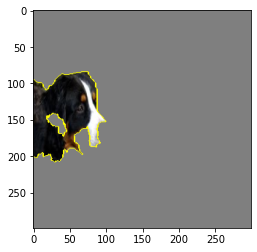

In [18]:
temp, mask = explanation.get_image_and_mask(240, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

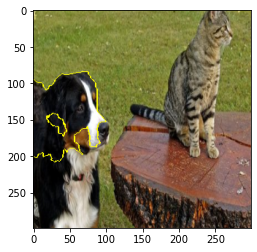

In [19]:
temp, mask = explanation.get_image_and_mask(240, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

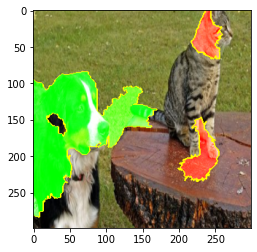

In [20]:
temp, mask = explanation.get_image_and_mask(240, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


Or the pros and cons that have weight at least 0.1

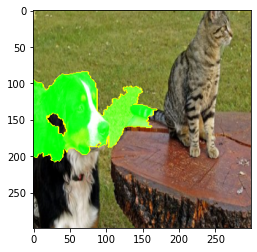

In [21]:
temp, mask = explanation.get_image_and_mask(240, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))